### Import libraries


In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
# Customize notebook with jupyterthemes
from jupyterthemes import jtplot as jt
# jt -t 'grade3' -fs 95 -altp -tfs 11 -nfs 115 -cellw 88% -T
jt.style(theme = 'grade3', context = 'notebook', ticks = True, grid = False)
# Postgres DB connector
import psycopg2
# Password for Postgres DB
from config import postpw

### Read Data


In [2]:
# Connection String for the Postgress database - Replace yourPW with the password you used when you installed Postgres
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format('127.0.0.1', 5432, 'Group6Final', 'postgres', postpw))

In [3]:
SQL = """SELECT "Age",
"Attrition",
"BUSINESSTRAVEL",
"DailyRate",
"Department",
"DistanceFromHome",
"Education",
"EDUCATIONFIELD",
"EmployeeCount",
"EmployeeNumber",
"EnvironmentSatisfaction",
"GENDER",
"HourlyRate",
"JobInvolvement",
"JobLevel",
"JOBROLE",
"JobSatisfaction",
"MARITALSTATUS",
"MonthlyIncome",
"MonthlyRate",
"NumCompaniesWorked",
"Over18",
"OverTime",
"PercentSalaryHike",
"PerformanceRating",
"RelationshipSatisfaction",
"StandardHours",
"StockOptionLevel",
"TotalWorkingYears",
"TrainingTimesLastYear",
"WorkLifeBalance",
"YearsAtCompany",
"YearsInCurrentRole",
"YearsSinceLastPromotion",
"YearsWithCurrManager",
"NumberProjects",
"WorkplaceAccident"
FROM "Employee_Status" AS ES
JOIN "CD_TRAVEL" CDT ON ES."BusinessTravel_FK" = CDT."BUSINESSTRAVEL_FK"
JOIN "CD_DEPARTMENT" CDD ON ES."Department_FK" = CDD."DEPARTMENT_FK"
JOIN "CD_EDUCATIONFIELD" CDE ON ES."EducationField_FK" = CDE."EDUCATIONFIELD_FK"
JOIN "CD_GENDER" CDG ON ES."Gender_FK" = CDG."GENDER_FK"
JOIN "CD_ROLE" CDR ON ES."JobRole_FK" = CDR."JOBROLE_FK"
JOIN "CD_M_STATUS" CDS ON ES."MaritalStatus_FK" = CDS."MARITALSTATUS_FK"""

In [4]:
# Need to add the double quotes back in at the end
SQL = SQL + '"'

In [5]:
# Read the file into a dataframe
hr_df = pd.read_sql_query(SQL, conn)

### Initial Analysis
- Any missing elements that need to be fixed
- Fix data issues


In [6]:
# Check the data and column names
hr_df.head()

,Age,Attrition,BUSINESSTRAVEL,DailyRate,Department,DistanceFromHome,Education,EDUCATIONFIELD,EmployeeCount,EmployeeNumber,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,0,8,0,1,6,4,0,5,2,0
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,1,10,3,3,10,7,1,7,5,0
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,7,3,3,0,0,0,0,7,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,0,8,3,3,8,7,3,0,5,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,1,6,3,3,2,2,2,2,2,0


In [7]:
# Rename column names so they are all consistent
hr_df.rename(columns = {'BUSINESSTRAVEL':'BusinessTravel','EDUCATIONFIELD':'EducationField','GENDER':'Gender','JOBROLE':'JobRole','MARITALSTATUS':'MaritalStatus' }, inplace = True)

In [8]:
# Verify the rename 
hr_df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'NumberProjects', 'WorkplaceAccident'],
      dtype='object')

In [9]:
# Check number of rows/columns
hr_df.shape

(1470, 37)

In [10]:
# Check for null values
hr_df.isnull().values.any()

False

In [11]:
# Another method to check for null values
hr_df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [12]:
# Another check for null values
hr_df.isnull()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1466,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1467,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1468,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
# Count of unique values in each column
hr_df.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

In [14]:
# Appears that columns EmployeeCount, Over18 and StandardHours all contain only 1 value
# Also, the EmployeeNumber is just an ID so it can be dropped

In [15]:
# Before we drop verify EmployeeCount values are the same for all employees
print(hr_df['EmployeeCount'].nunique())
print(hr_df['EmployeeCount'].unique())

1
[1]


In [16]:
# Before we drop verify Over18 values are the same for all employees
print(hr_df['Over18'].nunique())
print(hr_df['Over18'].nunique())

1
1


In [17]:
# Before we drop verify StandardHours values are the same for all employees
print(hr_df['StandardHours'].nunique())
print(hr_df['StandardHours'].unique())

1
[80]


In [18]:
hr_df = hr_df.drop(columns=['EmployeeNumber','EmployeeCount','Over18','StandardHours'])

In [19]:
# Verify 4 columns dropped
hr_df.shape

(1470, 33)

### Exploratory Phase
- Get data statistics 
- Visualize the data

In [20]:
# determine data types by column
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [21]:
# Which columns are considered categorical, we need this info later for the encoding
hr_df.select_dtypes(include='int64').columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumberProjects',
       'WorkplaceAccident'],
      dtype='object')

In [22]:
# Which columns are considered categorical, we need this info later for the encoding
hr_df.select_dtypes(include='object').columns

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime'],
      dtype='object')

In [23]:
# How manu numerical features
len(hr_df.select_dtypes(include='int64').columns)

25

In [24]:
# get df stats
hr_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,...,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,3.890476,0.051701
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,...,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,1.810522,0.221497
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,...,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,2.000000,0.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,...,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,4.000000,0.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,...,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,6.000000,0.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,...,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,7.000000,1.000000


In [25]:
# see all the columns with descriptive stats
pd.set_option('display.max_columns', None)
hr_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,3.890476,0.051701
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,1.810522,0.221497
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,2.000000,0.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,4.000000,0.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,6.000000,0.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,7.000000,1.000000


In [26]:
# random sample of the df
hr_df.sample(7)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
69,36,Yes,Travel_Rarely,318,Research & Development,9,3,Medical,4,Male,79,2,1,Research Scientist,3,Married,3388,21777,0,Yes,17,3,1,1,2,0,2,1,0,0,0,2,0
269,36,No,Travel_Rarely,1403,Research & Development,6,3,Life Sciences,4,Male,47,3,1,Laboratory Technician,4,Married,3210,20251,0,No,11,3,3,1,16,4,3,15,13,10,11,6,0
144,32,No,Travel_Frequently,689,Sales,9,2,Medical,4,Male,35,1,2,Sales Executive,4,Divorced,4668,22812,0,No,17,3,4,3,9,2,4,8,7,0,7,4,0
720,30,Yes,Travel_Rarely,138,Research & Development,22,3,Life Sciences,1,Female,48,3,1,Research Scientist,3,Married,2132,11539,4,Yes,11,3,2,0,7,2,3,5,2,0,1,2,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2,2,0
1352,44,No,Travel_Rarely,170,Research & Development,1,4,Life Sciences,2,Male,78,4,2,Healthcare Representative,1,Married,5033,9364,2,No,15,3,4,1,10,5,3,2,0,2,2,5,0
282,29,No,Travel_Frequently,442,Sales,2,2,Life Sciences,2,Male,44,3,2,Sales Executive,4,Single,4554,20260,1,No,18,3,1,0,10,3,2,10,7,0,9,5,0


<AxesSubplot:xlabel='Education', ylabel='DailyRate'>

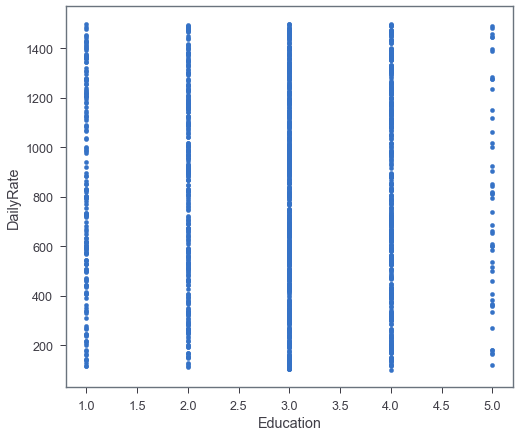

In [27]:
# look at running_time vs runtime using a scatter plot
hr_df.plot(x='Education', y='DailyRate', kind='scatter', color = 'b')

In [28]:
# Get a count of the target variable values
print("Count of Employees who stayed: ", (hr_df.Attrition == 'No').sum())
print("Count of Employees who left: ", (hr_df.Attrition == 'Yes').sum())

Count of Employees who stayed:  1233
Count of Employees who left:  237


D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


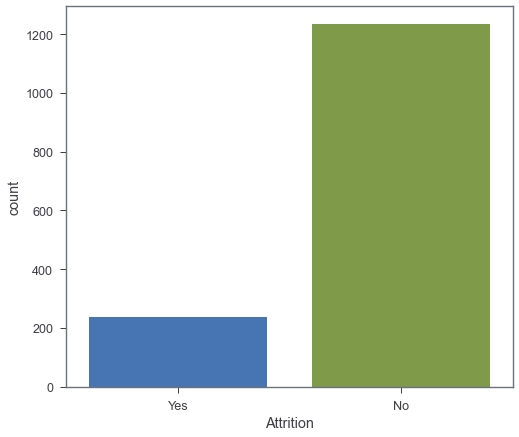

In [29]:
# Plot the target variable, how many instances of each value
sns.countplot(hr_df['Attrition'])
plt.show()

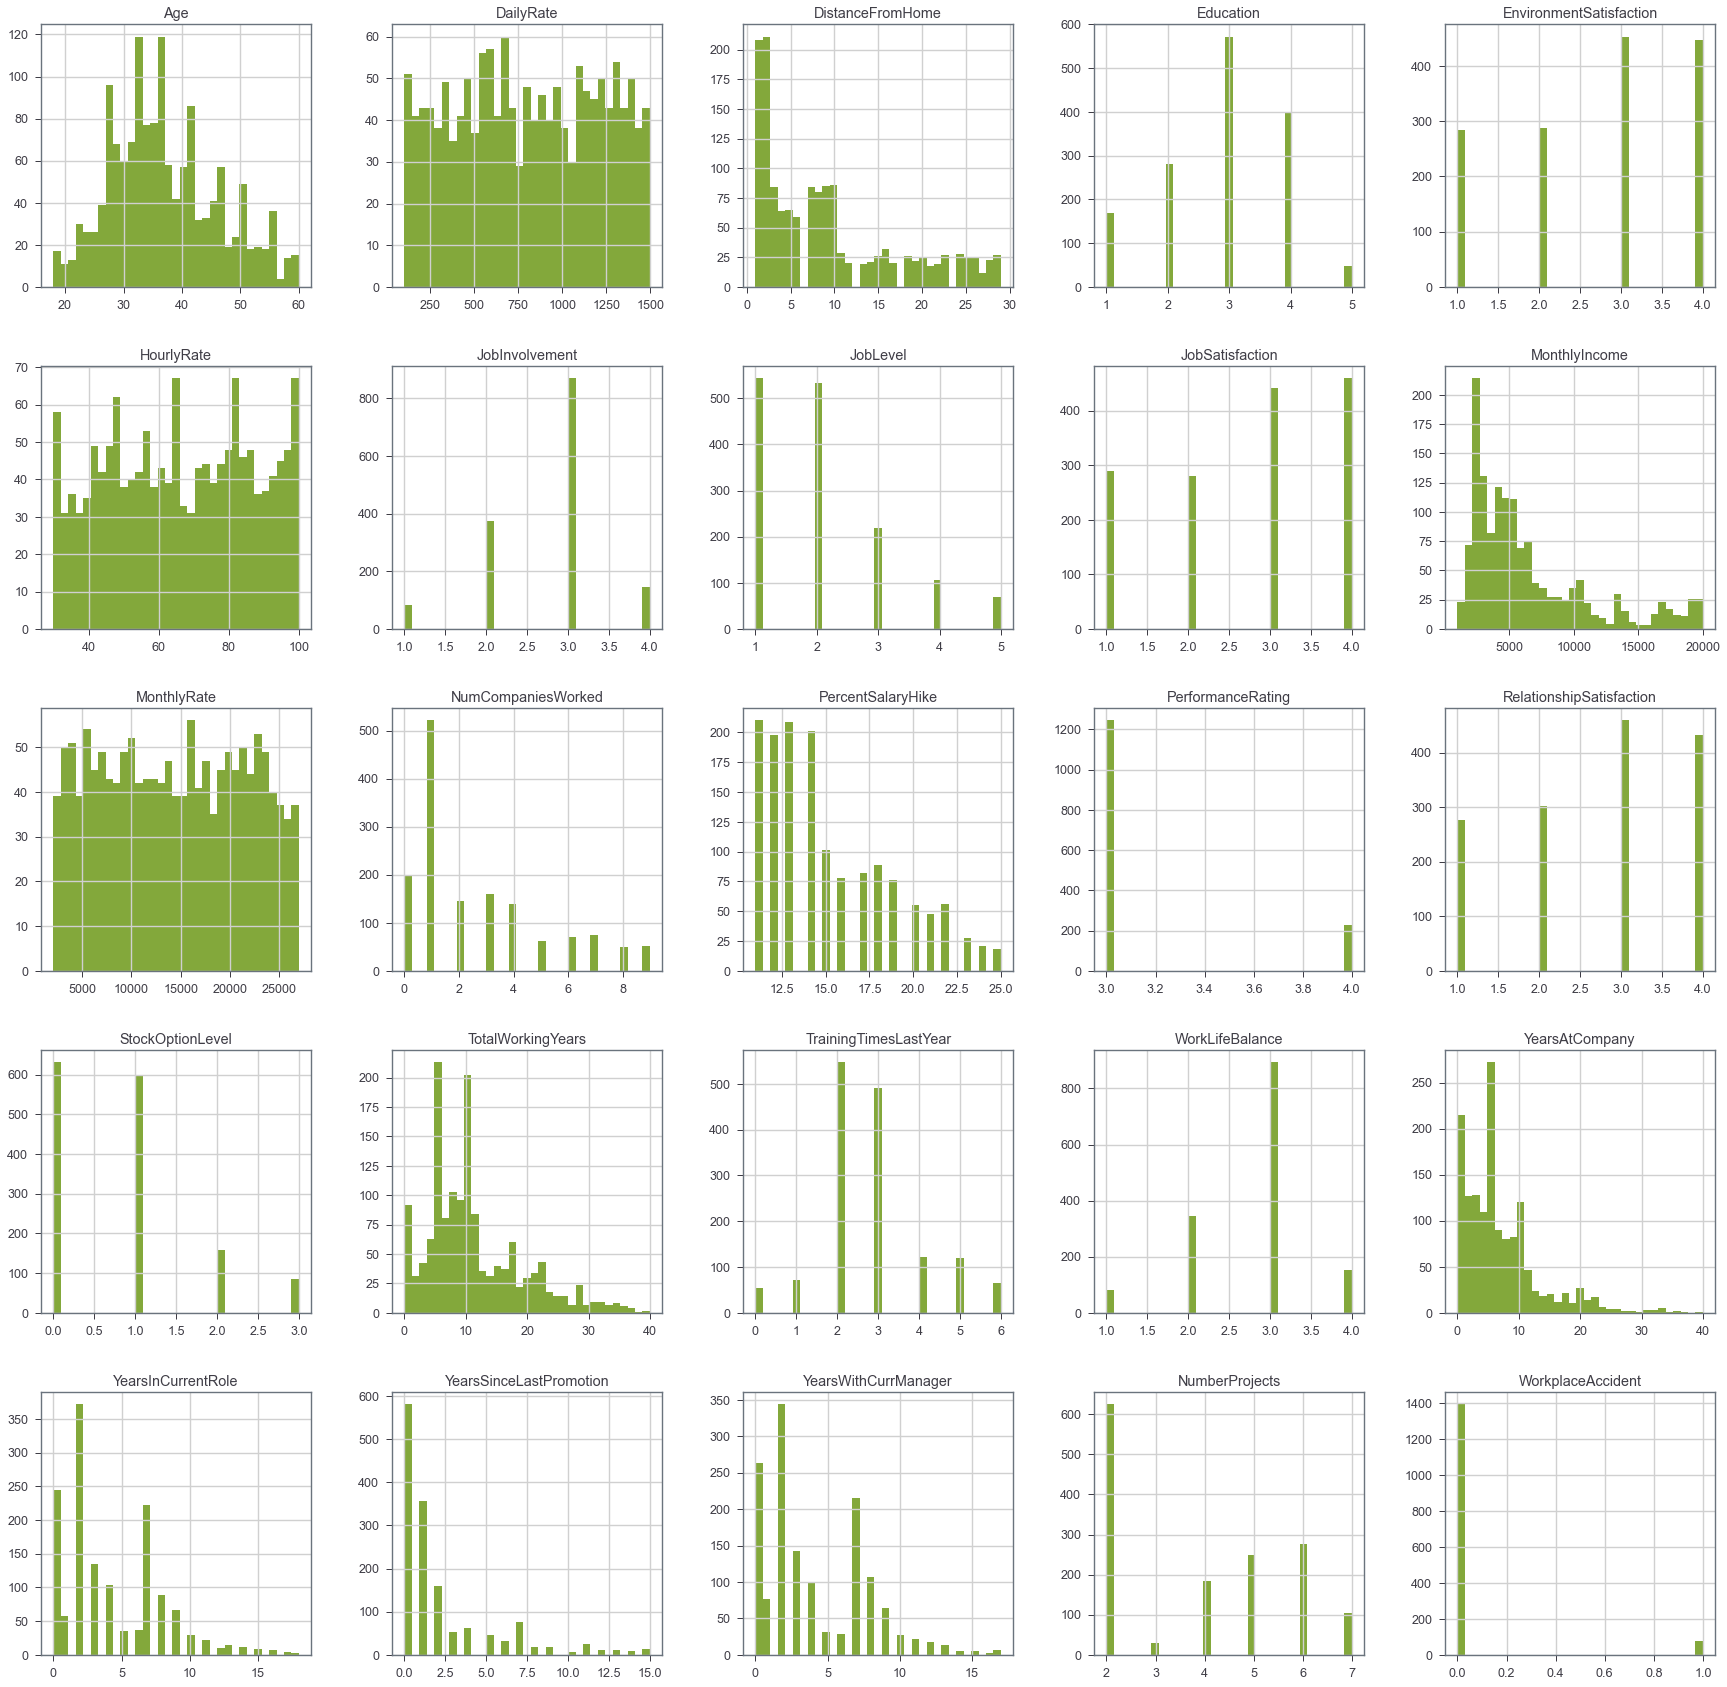

In [30]:
# Examine the distribution of the numerical features
hr_df.hist(bins = 33, figsize = (30,30), color = 'g');

In [31]:
hr_df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumberProjects',
       'WorkplaceAccident'],
      dtype='object')

<AxesSubplot:xlabel='Department', ylabel='count'>

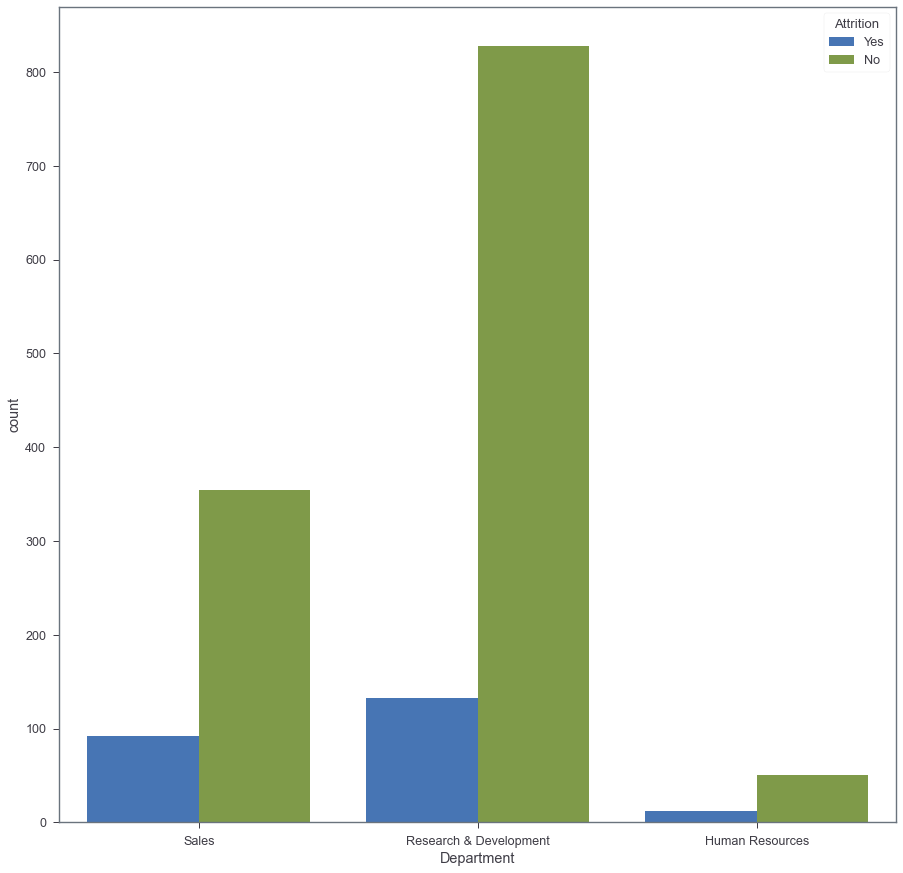

In [32]:
plt.figure(figsize=[15,15])
plt.subplot(111)
sns.countplot(x = 'Department', hue = 'Attrition', data = hr_df)

<AxesSubplot:xlabel='NumberProjects', ylabel='count'>

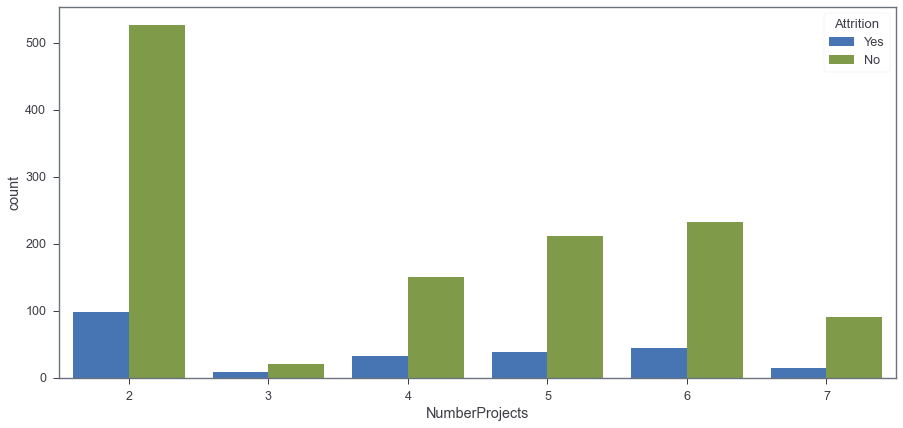

In [33]:
plt.figure(figsize=[15,15])
plt.subplot(211)
sns.countplot(x = 'NumberProjects', hue = 'Attrition', data = hr_df)

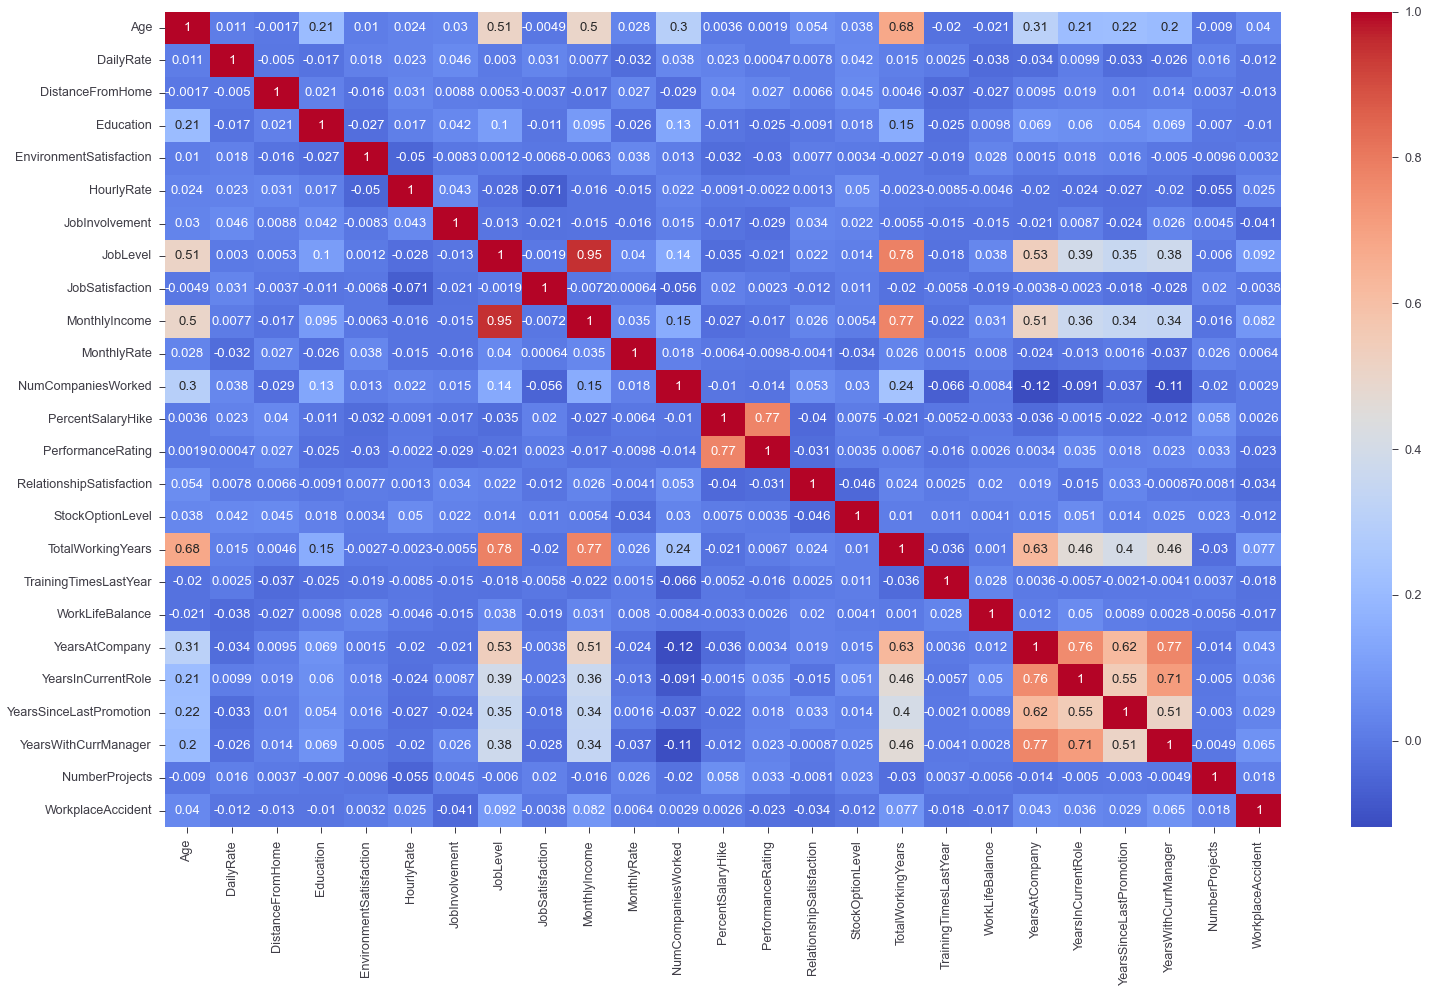

In [34]:
import seaborn as sns
# Examine correlations between features
correlation_matrix = hr_df.corr()
plt.figure(figsize=(25, 15))
heat_map = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm' )

### Transform Phase
- One hot encoding
- Reduction/Scaling


In [35]:
# Before OneHotEncoder check the number of rows and columns
hr_df.shape

(1470, 33)

In [36]:
# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder
#generate categorical variable list
hr_cat = hr_df.dtypes[hr_df.dtypes == "object"].index.tolist()

# check unique values
hr_df[hr_cat].nunique()

enc = OneHotEncoder(sparse=False)

#fit/transform
hr_encode = pd.DataFrame(enc.fit_transform(hr_df[hr_cat]))

# add names to df
hr_encode.columns = enc.get_feature_names(hr_cat)

# look at it
hr_encode.head()

D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [37]:
# merge/drop originals

hr_df = hr_df.merge(hr_encode, left_index=True, right_index=True)
hr_df = hr_df.drop(hr_cat, 1)

hr_df.head()

D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,2,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,5,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,7,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,5,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,2,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [38]:
hr_df.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumberProjects',
       'WorkplaceAccident', 'Attrition_No', 'Attrition_Yes',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 

In [39]:
# After OneHotEncoder check the number of rows and columns and the length, which should be 0
#   if all categorical columns are encoded
print(hr_df.shape)
print(len(hr_df.select_dtypes(include = "object").columns))

(1470, 55)
0


In [40]:
# split data into feature/target
y = hr_df['Attrition_Yes'].values
X = hr_df.drop(['Attrition_Yes', 'Attrition_No'], 1)
X.head()

D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,2,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,5,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,7,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,5,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [41]:
# Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=78)

In [42]:
print("X_train {}".format(X_train.shape))
print("X_test {}".format(X_test.shape))
print("y_train {}".format(y_train.shape))
print("y_test {}".format(y_test.shape))

X_train (1102, 53)
X_test (368, 53)
y_train (1102,)
y_test (368,)


In [43]:
# Reduction/Scaling
# scaling
from sklearn.preprocessing import StandardScaler ##?? MIN MAX SCALER?
# Create instance
scaler = StandardScaler()

# Fit 
X_scaler = scaler.fit(X_train)

# Scale 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [44]:
X_train_scaled

array([[-0.40942386, -1.6948152 ,  0.87475435, ...,  1.44758613,
         0.61581168, -0.61581168],
       [-1.29889668, -0.310834  , -0.50720476, ..., -0.69080518,
         0.61581168, -0.61581168],
       [-0.07587155,  1.62972131,  0.49785641, ..., -0.69080518,
        -1.62387305,  1.62387305],
       ...,
       [-0.18705565, -0.83510695, -0.63283741, ..., -0.69080518,
         0.61581168, -0.61581168],
       [-1.41008078, -0.65869283,  1.87981553, ..., -0.69080518,
         0.61581168, -0.61581168],
       [-0.63179206, -1.15563401, -0.00467417, ...,  1.44758613,
        -1.62387305,  1.62387305]])

In [45]:
X_test_scaled

array([[ 0.14649666,  1.72662484,  0.12095847, ..., -0.69080518,
         0.61581168, -0.61581168],
       [-0.85416027, -0.89225519, -0.13030682, ..., -0.69080518,
         0.61581168, -0.61581168],
       [ 0.59123307,  1.67444602, -0.50720476, ..., -0.69080518,
         0.61581168, -0.61581168],
       ...,
       [ 0.36886486,  0.92158013,  0.12095847, ..., -0.69080518,
        -1.62387305,  1.62387305],
       [-0.18705565, -0.33816577, -1.00973535, ..., -0.69080518,
         0.61581168, -0.61581168],
       [ 1.48070589, -1.33204813, -0.00467417, ..., -0.69080518,
        -1.62387305,  1.62387305]])


## Logistical Regression




### Build Model



In [46]:
# Import
from sklearn.linear_model import LogisticRegression

# create model
classifier = LogisticRegression()

# fit model
classifier.fit(X_train, y_train)

# validate model
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

# create predictions
LR_pred = classifier.predict(X_test)


## Warning:
# STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
# Increase the number of iterations (max_iter) or scale the data as shown in:
#     https://scikit-learn.org/stable/modules/preprocessing.html
# Please also refer to the documentation for alternative solver options:
#     https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
#   extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,

Training Data Score: 0.8312159709618875
Testing Data Score: 0.8722826086956522


D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [47]:
# Import
from sklearn.metrics import accuracy_score

acc_score = accuracy_score(y_test,LR_pred)
print("LR Accuracy Score = {0:.5g}%".format(acc_score * 100))

LR Accuracy Score = 87.228%


In [48]:
# Import
from sklearn.metrics import confusion_matrix

LR_confusion_matrix = confusion_matrix(y_test, LR_pred)
print("LR Confusion Matrix \n {}".format(LR_confusion_matrix))

LR Confusion Matrix 
 [[321   0]
 [ 47   0]]


In [49]:
balanced_accuracy_score(y_test, LR_pred)

LR_CM = confusion_matrix(y_test, LR_pred)

LR_cm_df = pd.DataFrame(
    LR_CM
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)

LR_cm_df.head()


,Predicted_high_risk,Predicted_low_risk
Actual_high_risk,321,0
Actual_low_risk,47,0


In [50]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, LR_pred))

# List the features sorted in descending order by feature importance - Not an option for Log regression
# features_rank_LR = sorted(zip(classifier.feature_importances_, X.columns), reverse=True)
# for feature in features_rank_LR:
#     print(f'{feature[1]}: ({feature[0]})')

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.87      1.00      0.00      0.93      0.00      0.00       321
        1.0       0.00      0.00      1.00      0.00      0.00      0.00        47

avg / total       0.76      0.87      0.13      0.81      0.00      0.00       368



D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



### Hyper parameter tuning
- Grid search
- Random search



### Apply tuned parameters to models



### Test Models
- Assess classification model accuracy
- Choose best performing model



## Random Forest



### Build Model



In [51]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)

# Fit
rf_classifier.fit(X_train, y_train)

rf_pred = rf_classifier.predict(X_test)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [52]:
acc_score = accuracy_score(y_test,rf_pred)
print("RF Accuracy Score = {0:.5g}%".format(acc_score * 100))

RF Accuracy Score = 87.772%


In [53]:
rf_confusion_matrix = confusion_matrix(y_test, rf_pred)
print("RF Confusion Matrix \n {}".format(rf_confusion_matrix))

RF Confusion Matrix 
 [[318   3]
 [ 42   5]]


In [56]:
# Calculated the balanced accuracy score
rf_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, rf_pred)

# Display the confusion matrix
cm = confusion_matrix(y_test, rf_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)


# Print the imbalanced classification report

print(classification_report_imbalanced(y_test, rf_pred))

# List the features sorted in descending order by feature importance
features_rank = sorted(zip(brf.feature_importances_, X.columns), reverse=True)
for feature in features_rank:
    print(f'{feature[1]}: ({feature[0]})')
    
cm_df.head()

NameError: name 'brf' is not defined


### Hyper parameter tuning
- Grid search
- Random search



### Apply tuned parameters to models



### Test Models
- Assess classification model accuracy
- Choose best performing model



## Support Vector Machine



### Build Model



In [57]:
# Documentation = https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm
from sklearn.svm import SVC

svc_classifier = SVC(random_state=44)
svc_classifier.fit(X_train, y_train)

SVC(random_state=44)

In [58]:
# Make the predictions
svc_pred = svc_classifier.predict(X_test)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [59]:
acc_score = accuracy_score(y_test,svc_pred)
print("SVC Accuracy Score = {0:.5g}%".format(acc_score * 100))

SVC Accuracy Score = 87.228%


In [60]:
svc_confusion_matrix = confusion_matrix(y_test, svc_pred)
print("SVC Confusion Matrix \n {}".format(svc_confusion_matrix))

SVC Confusion Matrix 
 [[321   0]
 [ 47   0]]



### Hyper parameter tuning
- Grid search
- Random search



### Apply tuned parameters to models



### Test Models
- Assess classification model accuracy
- Choose best performing model



## XGBoost



### Build Model



In [63]:
# Documentation = https://scikit-learn.org/stable/modules/classes.html
from sklearn.ensemble import GradientBoostingClassifier as XGB

xgb_classifier = XGB(random_state=44)
xgb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=44)

In [65]:
# Make the predictions
xgb_pred = xgb_classifier.predict(X_test)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [66]:
acc_score = accuracy_score(y_test,xgb_pred)
print("SVC Accuracy Score = {0:.5g}%".format(acc_score * 100))

SVC Accuracy Score = 88.315%


In [67]:
xgb_confusion_matrix = confusion_matrix(y_test, xgb_pred)
print("XGB Confusion Matrix \n {}".format(xgb_confusion_matrix))

XGB Confusion Matrix 
 [[315   6]
 [ 37  10]]



### Hyper parameter tuning
- Grid search
- Random search



### Apply tuned parameters to models



### Test Models
- Assess classification model accuracy
- Choose best performing model



## Naive Bayes



### Build Model



In [70]:
# Documentation = https://scikit-learn.org/stable/modules/classes.html
from sklearn.naive_bayes import GaussianNB as GNB

In [72]:
gnb_classifier = GNB()
gnb_classifier.fit(X_train, y_train)

GaussianNB()

In [73]:
# Make the predictions
gnb_pred = gnb_classifier.predict(X_test)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [74]:
acc_score = accuracy_score(y_test,gnb_pred)
print("Naive Bayes Accuracy Score = {0:.5g}%".format(acc_score * 100))

Naive Bayes Accuracy Score = 71.467%


In [75]:
gnb_confusion_matrix = confusion_matrix(y_test, gnb_pred)
print("XGB Confusion Matrix \n {}".format(xgb_confusion_matrix))

XGB Confusion Matrix 
 [[315   6]
 [ 37  10]]



### Hyper parameter tuning
- Grid search
- Random search



### Apply tuned parameters to models



## Test Models
- Assess classification model accuracy
- Choose best performing model



### Finalize Model